# Relajación de un sistema hacia el equilibrio

## Gustavo Adolfo Castrillón Yepes
## Instituto de Física, Universidad de Antioquia
## Calle 70 \# 52-21, Apartado Aéreo 1226, Medellín, Colombia.

## Abstract

## Palabras clave: Oscilador armonico, Temperatura, Métodos de montecarlo.


## Introducción 

En el presente notebook se realiza un análisis de cómo avanza un sistema en equilibrio, en especifico nos vamos a centrar en el estudio de un sistema de rendijas de dimensiones $3x3$ y $4x4$. En especifico nos vamos a centrar en el estudio de condiciones de frontera libre y periodicas, ademas, sin tener presente el teorema de ergodicidad, vamos a intentar replicarlo a partir de considerar diferentes posiciones. La idea, es llegar a demostrar como tal que, el sistema independiente de el tipo de rejilla que se considere y de las condiciones iniciales va a llegar el punto cuando alcance el equilibrio donde todas las probabilidades sean las mismas. 


## Explicación física del problema

En este notebook se plantea un codigo de Python el cual a partir de considerar matrices de transferencia, podemos conocer la evolución de una partícula a través de la posición. Ademas, se calcula la probabilidad de estar en cada punto de esta matriz o también conocida como la matriz de transferencia $\hat{P}$. Para esto vamos a construir dos sistemas reticulares 2D,  $3\times3$ celdas y $4\times4$ celdas, como se puede observar en la siguiente figura, para las figuras (a) y (b):

$$
\text{(a)}\quad
\begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & 6 \\ \hline
7 & 8 & 9 \\ \hline
\end{array}
\quad
\text{(b)}\quad
\begin{array}{|c|c|c|c|}
\hline
1 & 2 & 3 & 4 \\ \hline
5 & 6 & 7 & 8 \\ \hline
9 & 10 & 11 & 12 \\ \hline
13 & 14 & 15 & 16 \\ \hline
\end{array}
$$

Vamos a analizar dos tipos de condiciones de frontera, libres y periodicas, para ambas condiciones de frontera, únicamente vamos a considerar posibles transiciones a primeros vecinos, y apartir del tipo de condición primero vamos a calcular la matriz de transferencia y luego por medio de un algoritmo de metropolis se calcula la evolución de las condiciones a partir de un número de iteraciones maximas. 

## Condiciones de frontera libres (f.b.c)
Este es el primer caso, vamos a tener por expresarlo de alguna manera como tener fronteras con bordes. En este punto vamos a tener tres casos diferentes de casillas, casillas con: esquinas, aristas y medias. 

### Casillas con esquinas: 
Cuando se tiene una casilla de esquina, esta únicamenta va a poseer dos vecinos cercanos, por ejemplo, cuando miramos la imagen anterior y nos paramos en la casilla 9 para la rendija 3x3, esta únicamente tiene los vecinos $6$ y $8$. Por lo tanto, las reglas para estas condiciones van a ser las siguientes:
- Tendrá una probabilidad de quedarse en su misma casilla del valor de 1/2.
- La probabilidad de transicionar a uno de los vecinos sera de 1/4. 

### Casilla con aristas:
Cuando se tenga una casilla con arista, esta va a tener 3 vecinos cercanos. Por ejemplo, en la figura (a) vamos a tener la casilla 2, cuyos vecinos son: $1$, $3$ y $5$. Debido a esto las reglas para este tipo de casilla van a ser:
- La probabilidad de permanecer en la casilla es de 1/4.
- La probabilida de pasar a un vecino cercano es de 1/4.

### Casilla del medio: 

Por último, las casillas del medio poseen 4 vecinos cercanos, entonces vamos a definir que únicamente tienen posibilidades de pasar a un vecino y la probabilidad de permanecer en el mismo sitio va a ser igual a cero. Por lo tanto, las regla será:
- La probabilidad de transiciona a un vecino cercano es de 1/4.

Debemos tener que, la suma de todas las probabilidades debe ser igual a 1, debido a esto, por ejemplo en la casilla del medio la probabilidad de quedarnos en la misma casilla va a ser cero. Por otro lado, como esta suma debe ser igual a 1, debemos tener presente que todos los otros vecinos de una casilla diferentes a ser primeros vecinos tendrán una probabilidad igual a cero de transicionar o pasar a estas casillas. 

Con estas reglas es posible crear una matriz conocida como la matriz de transición. Esta nos da la información que tiene casa fila de pasar a una columna especifica.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def vecinos_fbc(i, j, n):
    '''
    Esta función me permite verificar cuales son los vecinos de un punto i,j 
    Los valores i, j van desde cero hasta n. 
    '''
    vecinos = []
    if i - 1 >= 0:
        vecinos.append((i - 1, j)) #Vecino de arriba
    if i + 1 < n:
        vecinos.append((i + 1, j)) #Vecino de abajo 
    if j - 1 >= 0:
        vecinos.append((i, j - 1)) #Vecino de izquierda 
    if j + 1 < n:
        vecinos.append((i, j + 1)) #Vecino de derecha 
    return vecinos


def establecer(pv,N):
    '''
    Esta función me permite tomar los primeros vecinos de cada punto y luego de eso calcula a partir de una formula la posición en el vector
    La idea es generar el vector en relación a ese punto que estamos estudiando de sus primeros vecinos y colocar el valor de la 
    probabilidad.
    La ecuación para calcular el punto del vecino en la probabilidad es: i*N + j
    '''
    vecindad = [0]*(N**2) #Un vector de N*N puntos 
    for i in pv:
        vecino = i[0]*N + i[1]
        vecindad[vecino] = 1/4 #Si es un vecino le asigno el valor de 1/4 a la probabilidad 
    return vecindad
     
def verificar_tipo(i,j,N):
    '''
    Tenemos 3 casos especificos independientes de la matriz N. 
    Primer caso: Si estamos en una esquina, en este caso los vecinos serán únicamente 2
    Segundo caso: Si estamos en una arista, en este caso los vecinos serán 3
    Tercer caso: Si estamos en el medio, en este caso los vecinos son 4. 
    No tenemos mayor cantidad de vecinos si únicamente estamos considerando los primeros vecinos.
    '''
    pv = vecinos_fbc(i,j,N) #Sacamos la cantidad de vecinos de la posición i,j 
    tamanio = len(pv) #Miramos el tamaño del arreglo.
    if tamanio == 2: #Si tenemos dos vecinos, tenemos una esquina
        vector = establecer(pv,N)
        vector[i*N + j] = 1/2 #La probabilidad de quedarnos en esa esquina es de 1/2
    elif tamanio == 3: #Si tenemos 3 vecinos, tenemos una arista
        vector = establecer(pv,N)
        vector[i*N + j] = 1/4 #La probabilidad de quedarnos en esa arista es de 1/4
    elif tamanio == 4: #Si tenemos 4 vecinos, tenemos un punto medio.
        vector = establecer(pv,N) 
        #Aquí no tenemos una probabilidad de quedarnos en ese sitio. 
    else: #En caso tal de que el programa falle muestra un mensaje. 
        print("No se puede establecer")
    return vector #Devuelve el vector para cada punto i,j,N. 
    
def generar_matriz_P_fbc(N):
    '''
    Debemos utilizar todo el codigo anterior para generar la matriz de probabilidad. 
    Para esto debemos recorrer todos los valores en el arreglo (i,j) que iría desde 0 hasta N, cada uno de estos.
    '''
    matrizPP = []
    for i in range(N):
        for j in range(N):
            matrizPP.append(verificar_tipo(i,j,N))
    return np.array(matrizPP) #Al final a retornar una matriz de probabilidad.

## Condiciones de frontera periodicas (p.b.c)
Para este caso, las condiciones de transición entre las casillas estan dadas por la figura que se muestra abajo, aquí aunque la partícula este en una casilla de la esquina, las probabilidades de transición van a ser diferentes. Un ejemplo de estos es cuando estamos en la casilla 9 el primer vecino de la parte inferior va a ser el valor $3$. Por lo tanto, únicamente vamos a considerar transiciones a primeros vecinos y esto lo vamos a hacer considerando que, la probabilidad de pasar a cualquier primer vecino va a ser igual a $1/4$.  

$$
\begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & \cellcolor{black}\textcolor{white}{\textbf{6}} \\ \hline
7 & 8 & 9 \\ \hline
\end{array}
$$

$$
\uparrow
$$

$$
\begin{align*}
\begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & 6 \\ \hline
7 & \cellcolor{black}\textcolor{white}{\textbf{8}} & 9 \\ \hline
\end{array}
\leftarrow
&\quad
\begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & 6 \\ \hline
7 & 8 & \cellcolor{black}\textcolor{white}{\textbf{9}} \\ \hline
\end{array}
\quad
\rightarrow
\quad
\begin{array}{|c|c|c|}
\hline
1 & 2 & 3\\ \hline
4 & 5 & 6 \\ \hline
\cellcolor{black}\textcolor{white}{\textbf{7}} & 8 & 9 \\ \hline
\end{array}
\quad
\end{align*}
$$

$$
\downarrow
$$
$$
\begin{array}{|c|c|c|}
\hline
1 & 2 &  \cellcolor{black}\textcolor{white}{\textbf{3}} \\ \hline
4 & 5 & 6 \\ \hline
7 & 8 & 9 \\ \hline
\end{array}
$$

Como se percibe en la imagen, ya no existe una diferencia entre el tipo de casillas y el lugar de eso, estamos volviendo a otras casillas de la misma malla. Debido a esto, se definen como "condiciones de frontera periodicas".

In [3]:
def vecinos_pbc(i,j,n):
    vecinos = [] 
    #Vecino de arriba
    if i -1 >=0:
        vecinos.append((i-1,j))
    else: 
    #En caso que no tenga un vecino superior, vamos a pasar a la casilla más superior.
        vecinos.append((n-1, j))
    #Vecino de abajo 
    if i + 1 < n:
        vecinos.append((i + 1, j)) 
    else: 
    #En caso de no tener un vecino inferior, vamos a pasar a la casilla más inferior de la malla.
        vecinos.append((0, j))
    #Vecino de izquierda
    if j - 1 >= 0:
        vecinos.append((i, j - 1))
    else: 
        vecinos.append((i,n-1))
     #Vecino de derecha
    if j + 1 < n:
        vecinos.append((i, j + 1))
    else: 
        vecinos.append((i,0))
    return vecinos

def generar_matriz_P_pbc(N):
    '''
    Debemos utilizar todo el codigo anterior para generar la matriz de probabilidad. 
    Para esto debemos recorrer todos los valores en el arreglo (i,j) que iría desde 0 hasta N, cada uno de estos.
    '''
    matrizPP = []
    for i in range(N):
        for j in range(N):
            pv = vecinos_pbc(i,j,N)
            #print(pv)
            matrizPP.append(establecer(pv,N))
    return np.array(matrizPP) #Al final vamos a generar una matriz de probabilidad periodica.

Para no tener que trabajar de forma aleatoria sin saber si estamos haciendo los métodos de una forma correcta. Vamos a utilizar de inicio el modelo 3x3. Entonces, la matriz de transición de este modelo va a ser la siguiente:

In [4]:
matrizP1 = [1/2, 1/4,   0, 1/4,   0,   0,   0,   0,   0]
matrizP2 = [1/4, 1/4, 1/4,   0, 1/4,   0,   0,   0,   0]
matrizP3 = [  0, 1/4, 1/2,   0,   0, 1/4,   0,   0,   0]
matrizP4 = [1/4,   0,   0, 1/4, 1/4,   0, 1/4,   0,   0]
matrizP5 = [  0, 1/4,   0, 1/4,   0, 1/4,   0, 1/4,   0]
matrizP6 = [  0,   0, 1/4,   0, 1/4, 1/4,   0,   0, 1/4]
matrizP7 = [  0,   0,   0, 1/4,   0,   0, 1/2, 1/4,   0]
matrizP8 = [  0,   0,   0,   0, 1/4,   0, 1/4, 1/4, 1/4] 
matrizP9 = [  0,   0,   0,   0,   0, 1/4,   0, 1/4, 1/2]

matrizP = np.array([matrizP1, matrizP2, matrizP3, matrizP4, matrizP5, matrizP6, matrizP7, matrizP8, matrizP9])
print(matrizP) #Esta es la matriz calculada de forma teorica para un sistema reticular 3x3.

[[0.5  0.25 0.   0.25 0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.   0.25 0.   0.   0.   0.  ]
 [0.   0.25 0.5  0.   0.   0.25 0.   0.   0.  ]
 [0.25 0.   0.   0.25 0.25 0.   0.25 0.   0.  ]
 [0.   0.25 0.   0.25 0.   0.25 0.   0.25 0.  ]
 [0.   0.   0.25 0.   0.25 0.25 0.   0.   0.25]
 [0.   0.   0.   0.25 0.   0.   0.5  0.25 0.  ]
 [0.   0.   0.   0.   0.25 0.   0.25 0.25 0.25]
 [0.   0.   0.   0.   0.   0.25 0.   0.25 0.5 ]]


Luego vamos a comparar esta matriz de transición punto a punto con la calculada por el algoritmo.

In [5]:
'''
Es necesario verificar que, estamos generando la matriz correctamente, para esto lo que hacemos es compararla con la matriz 
generada en clase. 
'''
generar_matriz_P_fbc(3) == matrizP

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

Aquí vemos que, efectivamente es posible por medio del algoritmo replicar la matriz de transición. 
Por otro lado, sabemos que estas matrices deben tener un comportamiento simetrico, por lo tanto es importante utilizar esta clase de filtros para verificar que la matriz lo cumple, para esto se generó la siguiente línea de codigo.

In [6]:
#Es posible verificar otra cualidad de la matriz y es su simetria. 
def es_simetrica(A):
    return np.array_equal(A, A.T) #Para verificar que la matriz de transferencia sea simetrica
    
#Si arroja True, es porque la matriz es simetrica y entonces cumple otra condición de la matriz.

In [7]:
def verificar_suma(matriz):
    elementos = []
    flag = True
    for i in matriz:
        elementos.append(round(sum(i),1))
    for j in elementos:
        if (not (0.99 <= j <= 1.01)):
            flag = False
            print("Error, la suma de los elementos no es cercana a 1")
            print(f"La suma es: {j}")
    print(flag)

In [8]:
#Ejemplo cuando la suma de las filas de la matriz son diferente de 1. 
matrizppp = [[1,2],[3,4]]
verificar_suma(matrizppp)

Error, la suma de los elementos no es cercana a 1
La suma es: 3
Error, la suma de los elementos no es cercana a 1
La suma es: 7
False


# Caso f.b.c con matriz 3x3

In [9]:
matriz1 = generar_matriz_P_fbc(3) #Matiz 3x3 con condiciones libres 
es_simetrica(matriz1) #Verificamos que la matriz 3x3 sea simetrica

True

Como se puede observar, ya se poseen 2 filtros por medio de los cuales es posible verificar que, el algoritmo funciona correctamente a lo esperado, sin embargo, para problemas de dimensión mayor a 3, sería engorroso estar calculando la matriz a mano y compararla con este valor. Por lo tanto, aunque no es un parámetro que nos pueda indicar que, la matriz esta bien construida, un primer filtro para verificar la construcción de esta matriz sería el verificar si es simetrica o no.

Por otro lado, podemos plantear otro filtro, al final todas la suma de todos los elementos de cada fila de la matriz deben ser igual a 1. En caso contrario, pues la matriz no se estaría construyendo de manera adecuada. Esto también puede ser otro filtro para verificar que, las matrices que estamos construyendo son validas. Por ejemplo, para la matriz creada anteriormente vamos a tener: 

In [10]:
verificar_suma(matriz1) #Verificamos la matriz1 (para las condiciones f.b.c)

True


Otra forma de verificar que el método esta funcionando correctamente es que sabemos que, cuando la condición inicial inicia en la casilla nueve, o sea, partimo de la casilla 9, el primer paso debe dar unos valores especificos, como ultima verificación vamos a realizar este paso y verificar que el procedimiento se este realizando adecuadamente.

In [11]:
#Otra prueba importante a realizar es poder replicar el primer paso realizado en clase. 
#Para esto debemos verificar que, Matrizp por omega0 sea igual a omega1

omega0 = np.array([0,0,0,0,0,0,0,0,1]) #Vector inicial 
omega1 = np.array([0,0,0,0,0, 1/4, 0, 1/4, 1/2]) #Vector final 

omega0 @ matriz1 == omega1 #Verificamos si el resultado es igual al calculado teoricamente

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

Aquí es posible verificar que, el primer paso con la matriz creada si genera los valores que esperaríamos. 

Se consideran 3 condiciones iniciales. Estas se pueden observar en el gráfico de abajo: 

### 1. Estar en una esquina. 
$$
\Omega_{0} = \begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & 6 \\ \hline
7 & 8 & \cellcolor{black}\textcolor{white}{\textbf{9}} \\ \hline
\end{array}
$$

### 2. Estar en una arista. 
$$
\Omega_{1} = \begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & 6 \\ \hline
7 & \cellcolor{black}\textcolor{white}{\textbf{8}} & 9 \\ \hline
\end{array}
$$

### 3. Estar en el medio. 
$$
\Omega_{2} = \begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & \cellcolor{black}\textcolor{white}{\textbf{5}} & 6 \\ \hline
7 & 8 & 9 \\ \hline
\end{array}
$$

Para el algoritmos las condiciones iniciales van a tomar la siguiente forma:

In [12]:
#Establecemos 3 configuraciones iniciales  
omega0_0 = np.array([0,0,0,0,0,0,0,0,1]) #Cuando nos encontramos en una esquina
omega0_1 = np.array([0,0,0,0,0,1,0,0,0]) #Cuando nos encontramos en una arista
omega0_2 = np.array([0,0,0,0,1,0,0,0,0]) #Cuando nos encontramos en una casilla del centro

El algoritmo va a consistir en tener una multiplicación de la matriz de transferencia por el vector inmediatamente anterior. A este algoritmo únicamente debemos pasarle una condición inicial y una matriz de transferencia. El va a realizar la multiplicación menionada anteriormente una cantidad de veces hasta se llegue a un valor de convergencia o se alcance un número maximo de iteraciones.

Para esta evaluar la convergencia del algoritmo se va a usar dos condiciones, la primera va a estar dada por: 

$$\sum_{i} |\Omega_{i} - \Omega_{i+1}| < \text{ tolerancia} \text{.}$$

La segunda va a estar determinada por la entropía. Esto ya que, un sistema en partícular puede estar oscilando eternamente entre estados pero haber llegado al equilibrio, entones vamos a considerar esta condición: 

$$ |S_{i} - S_{i+1}| < \text{tolerancia} \text{.}$$

Para que el algoritmo se detegan es necesario que se cumpla una de estas dos condiciones. Ademas, en caso de tener un sistema que no cumpla estas condiciones, se plantea un número maximo de iteraciones, esto se hace con el fin de evitar bucles infinitos.

In [13]:
#Para evaluar la convergencia del algoritmo vamos a utilizar las siguientes funciones.
operacion = lambda i, j: abs(i - j)
def ha_convergido(pi_new, entropy_new, pi_old, entropy_old, tol=1e-6):
    #Vamos a usar dos condiciones, la primera es cuando tenga un sistema donde la diferencia entre ambos valores sea minima
    #La otra es cuando la diferencia entre las entropias de dos puntos no cambie más alla del valor de tolerancia, entonces también arrojo
    #true.
    return (np.sum(np.abs(pi_new - pi_old)) < tol) or (np.abs(entropy_new - entropy_old) < tol)

In [14]:
def entropia_shannon(pi):
    #Calculamos la entropía de Shannon.
    mask = pi > 0  # Filtra solo probabilidades > 0
    return -np.sum(pi[mask] * np.log(pi[mask])) #Retorna la entropia de Shannon.

def metodo_de_transicion(omega0_, matrizP, tolerancia = 1e-6, max_iter=100000):
    datos = [] #Almacena las probabilidades
    entropia = [] #Almacena los valores de entropía.
    entropia0 = entropia_shannon(omega0_) #Calculamos la entropía inicial 
    entropia.append(entropia0) #Almacenamos el valor inicial de la entropía.
    datos.append(omega0_) #Almacenamos el valor inicial.
    flag = True #Para ejecutar el programa.
    i = 0 #Contador de iteraciones
    while(flag):
        omegai = datos[-1] @ matrizP  #Realizamos el producto entre el vector y la matriz de transferencia
        entropiai = entropia_shannon(omegai) #Calculamos la entropía de la última transición
        datos.append(omegai) #Guardamos el valor de las probabilidades
        entropia.append(entropiai) #Guardamos el valor i de la entropia.
        i+=1 #Aumentamos el contador 
        if( ha_convergido(datos[-1],entropia[-1],datos[-2],entropia[-2], tol = tolerancia) or (i == max_iter)):
            #Verificamos si el algoritmo converge
            flag = False #En caso de convergen, establecemos la bandera como False y acaba el bucle. 
    return np.array(datos), np.array(entropia) #Retornamos los valores de pi(x) y la entropia.

In [15]:
#Aquí estamos considerando las transiciones para las diferentes condiciones iniciales
datos1 = metodo_de_transicion(omega0_0,matriz1) 
datos2 = metodo_de_transicion(omega0_1,matriz1)
datos3 = metodo_de_transicion(omega0_2,matriz1)

In [16]:
# Creamos unos vectores de iteranciones.
x1 = range(len(datos1[1])) 
x2 = range(len(datos2[1])) 
x3 = range(len(datos3[1])) 

y1 = datos1[0]
y2 = datos2[0]
y3 = datos3[0]

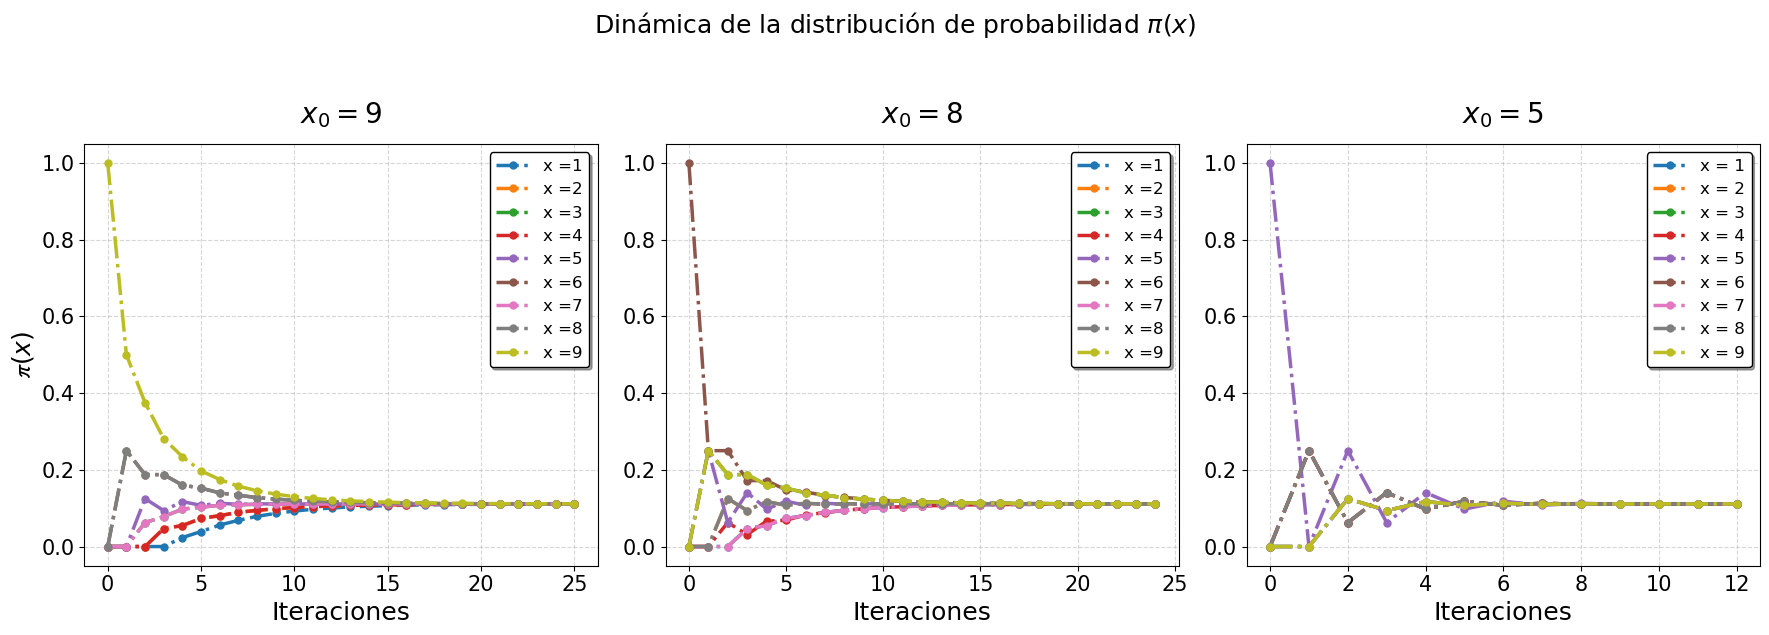

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6)) 

fig.suptitle(r'Dinámica de la distribución de probabilidad $\pi(x)$', size=18, y=1.05)  # Título general

# --- Gráfico 1 ---
for i in range(len(y1.T)):
    ax1.plot(x1,y1.T[i], '-.', linewidth=2.5, markersize=5
             ,label='x =' +str(i+1), marker='o')
ax1.set_title(r'$x_{0} = 9$', size=20, pad=15, weight='bold')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Iteraciones', size=18)
ax1.set_ylabel(r'$\mathcal{\pi}(x)$', size=18)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')

# --- Gráfico 2 ---
for i in range(len(y2.T)):
    ax2.plot(x2,y2.T[i], '-.', linewidth=2.5, markersize=5
             ,label='x =' +str(i+1), marker='o')
ax2.set_title(r'$x_{0} = 8$', size=20, pad=15)
ax2.set_xlabel('Iteraciones', size=18)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')

# --- Gráfico 3 ---
for i in range(len(y3.T)):
    ax3.plot(x3,y3.T[i], '-.', linewidth=2.5, markersize=5
             ,label='x = ' +str(i+1), marker='o')
ax3.set_title(r'$x_{0} = 5$', size=20, pad=15)
ax3.set_xlabel('Iteraciones', size=18)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black')

# Ajustar espacios y guardar
plt.tight_layout()
#plt.savefig('entropia_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_17287/2466272199.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-+" (-> marker='+'). The keyword argument will take precedence.
  plt.plot(x2, datos2[1], '-+', linewidth=2.5, markersize=5,
/tmp/ipykernel_17287/2466272199.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-^" (-> marker='^'). The keyword argument will take precedence.
  plt.plot(x3, datos3[1], '-^', linewidth=2.5, markersize=5,


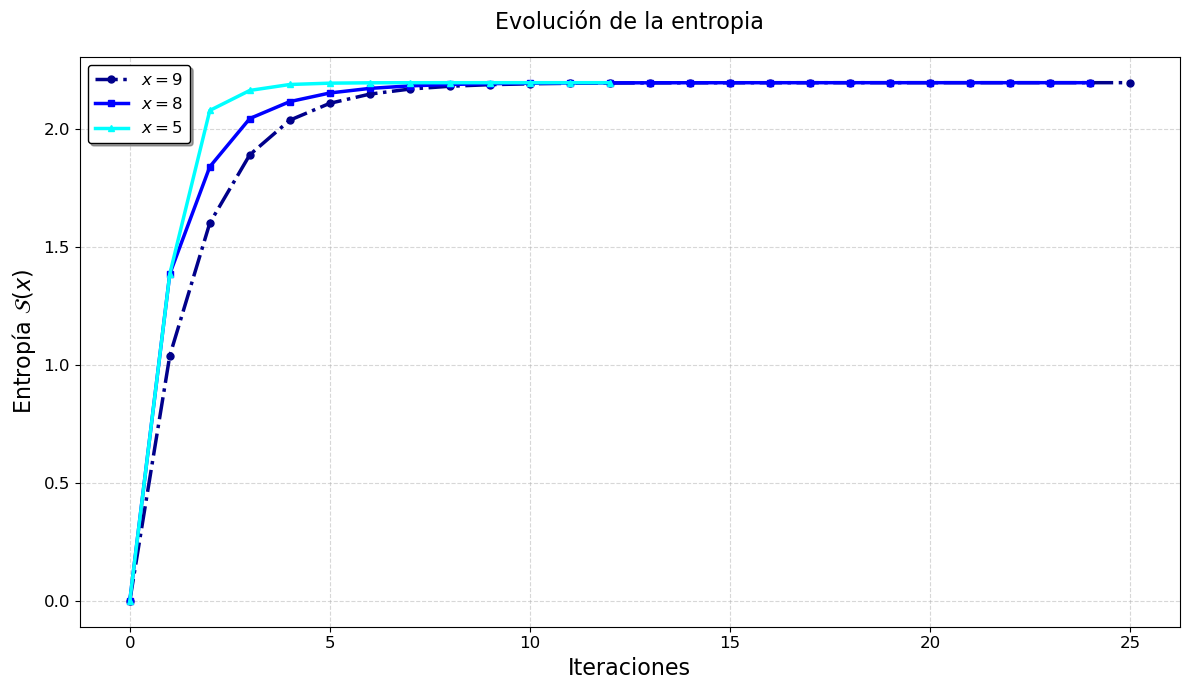

In [18]:
plt.figure(figsize=(12, 7))  
plt.plot(x1, datos1[1], '-.', linewidth=2.5, markersize=5, 
         label=r'$x = 9$', color='darkblue', marker='o')
plt.plot(x2, datos2[1], '-+', linewidth=2.5, markersize=5, 
         label=r'$x = 8$', color='blue', marker='s')
plt.plot(x3, datos3[1], '-^', linewidth=2.5, markersize=5, 
         label=r'$x = 5$', color='cyan', marker='^')

plt.title(r'Evolución de la entropia', size=16, pad=20)
plt.xlabel(r'Iteraciones', size=16)
plt.ylabel(r'Entropía $\mathcal{S}(x)$', size=16)


plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12, framealpha=1, shadow=True, 
           fancybox=True, loc='best', edgecolor='black')

plt.tight_layout()

#guardar la figura con alta resolución -> pdi = 300
# plt.savefig('entropia.png', dpi=300)
plt.show()

### Sistema 4x4.

Primero creamos la matriz de transición y la sometemos a los mismos filtros que para la matriz $3x3#. 

In [19]:
matriz2 = generar_matriz_P_fbc(4) #Matriz 4x4 con f.b.c.
es_simetrica(matriz2) #Verificamos que la matriz 4x4 sea simetrica

True

In [20]:
verificar_suma(matriz2)

True


Vamos a considerar tres condiciones iniciales con el mismo tratamiento que para el problema $3x3$. Esto significa que estamos tomando una esquina, una arista y una casilla del medio.

### 1. Estar en una esquina. 
$$
\begin{array}{|c|c|c|c|}
\hline
1 & 2 & 3 & 4 \\ \hline
5 & 6 & 7 & 8 \\ \hline
9 & 10 & 11 & 12 \\ \hline
13 & 14 & 15 & \cellcolor{black}\textcolor{white}{\textbf{16}} \\ \hline
\end{array}
$$

### 2. Estar en una arista. 
$$
\begin{array}{|c|c|c|c|}
\hline
1 & 2 & 3 & 4 \\ \hline
5 & 6 & 7 & 8 \\ \hline
9 & 10 & 11 & \cellcolor{black}\textcolor{white}{\textbf{12}} \\ \hline
13 & 14 & 15 & 16 \\ \hline
\end{array}
$$

### 3. Estar en el medio. 
$$
\begin{array}{|c|c|c|c|}
\hline
1 & 2 & 3 & 4 \\ \hline
5 & 6 &\cellcolor{black}\textcolor{white}{\textbf{7}}  & 8 \\ \hline
9 & 10 & 11 & 12 \\ \hline
13 & 14 & 15 & 16 \\ \hline
\end{array}
$$

In [21]:
omega1_0 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])
omega1_1 = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])
omega1_2 = np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1])

Sometemos estas condiciones iniciales al método definido anteriomente.

In [22]:
#Ejecutamos el metodo
datos1_4_fbc = metodo_de_transicion(omega1_0, matriz2)
datos2_4_fbc = metodo_de_transicion(omega1_1, matriz2)
datos3_4_fbc = metodo_de_transicion(omega1_2, matriz2)

In [23]:
# Creamos unos vectores de iteranciones.
x1 = range(len(datos1_4_fbc[1])) 
x2 = range(len(datos2_4_fbc[1])) 
x3 = range(len(datos3_4_fbc[1])) 

y1 = datos1_4_fbc[0]
y2 = datos2_4_fbc[0]
y3 = datos3_4_fbc[0]

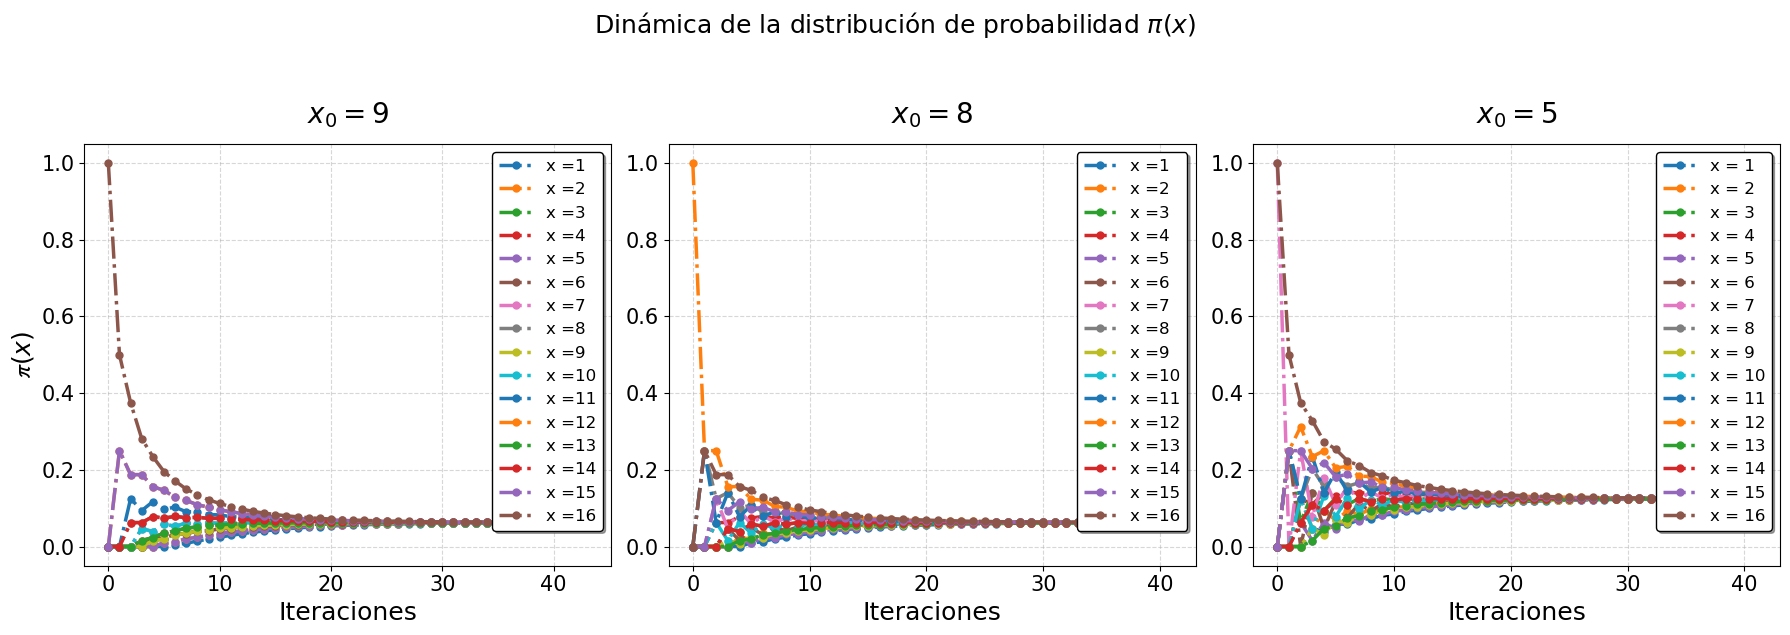

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6)) 

fig.suptitle(r'Dinámica de la distribución de probabilidad $\pi(x)$', size=18, y=1.05)  # Título general

# --- Gráfico 1 ---
for i in range(len(y1.T)):
    ax1.plot(x1,y1.T[i], '-.', linewidth=2.5, markersize=5
             ,label='x =' +str(i+1), marker='o')
ax1.set_title(r'$x_{0} = 9$', size=20, pad=15, weight='bold')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Iteraciones', size=18)
ax1.set_ylabel(r'$\mathcal{\pi}(x)$', size=18)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black',loc='upper right')

# --- Gráfico 2 ---
for i in range(len(y2.T)):
    ax2.plot(x2,y2.T[i], '-.', linewidth=2.5, markersize=5
             ,label='x =' +str(i+1), marker='o')
ax2.set_title(r'$x_{0} = 8$', size=20, pad=15)
ax2.set_xlabel('Iteraciones', size=18)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black',loc='upper right')

# --- Gráfico 3 ---
for i in range(len(y3.T)):
    ax3.plot(x3,y3.T[i], '-.', linewidth=2.5, markersize=5
             ,label='x = ' +str(i+1), marker='o')
ax3.set_title(r'$x_{0} = 5$', size=20, pad=15)
ax3.set_xlabel('Iteraciones', size=18)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend(fontsize=12, framealpha=1, shadow=True, edgecolor='black',loc='upper right')

# Ajustar espacios y guardar
plt.tight_layout()
#plt.savefig('entropia_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (44,) and (26,)

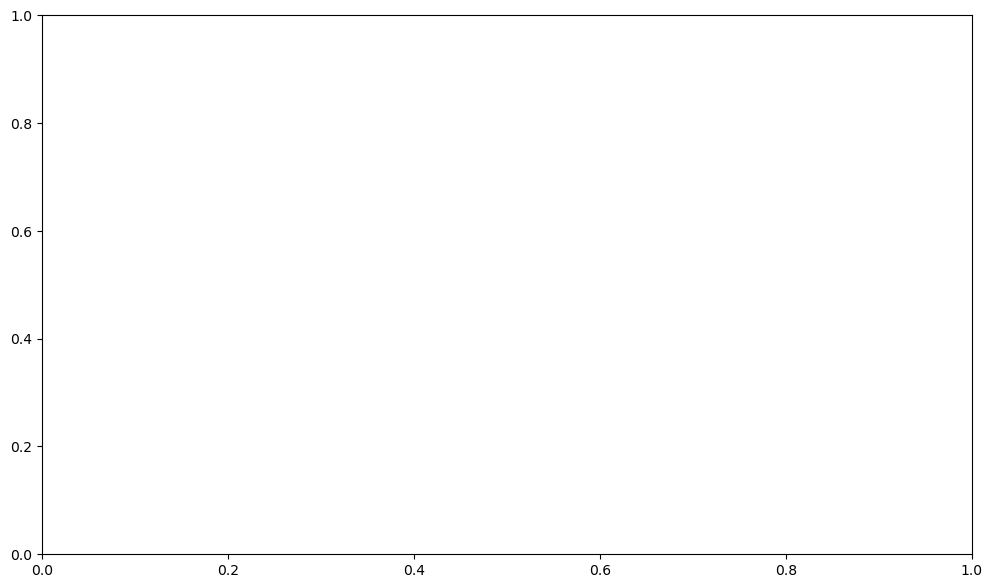

In [25]:
plt.figure(figsize=(12, 7))  
plt.plot(x1, datos1[1], '-.', linewidth=2.5, markersize=5, 
         label=r'$x = 9$', color='darkblue', marker='o')
plt.plot(x2, datos2[1], '-+', linewidth=2.5, markersize=5, 
         label=r'$x = 8$', color='blue', marker='s')
plt.plot(x3, datos3[1], '-^', linewidth=2.5, markersize=5, 
         label=r'$x = 5$', color='cyan', marker='^')

plt.title(r'Evolución de la entropia', size=16, pad=20)
plt.xlabel(r'Iteraciones', size=16)
plt.ylabel(r'Entropía $\mathcal{S}(x)$', size=16)


plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12, framealpha=1, shadow=True, 
           fancybox=True, loc='best', edgecolor='black')

plt.tight_layout()

#guardar la figura con alta resolución -> pdi = 300
# plt.savefig('entropia.png', dpi=300)
plt.show()

In [ ]:
matriz1_pbc = generar_matriz_P_pbc(3) #Matriz 3x3 con condiciones periodicas
es_simetrica(matriz1_pbc) #Verificamos que la matriz 3x3 sea simetrica

In [ ]:
verificar_suma(matriz2_pbc)

In [ ]:
matriz2_pbc = generar_matriz_P_pbc(4) #Matriz 4x4 con condiciones periodicas
es_simetrica(matriz2_pbc) #Verificamos que la matriz 4x4 sea simetrica

In [ ]:
datos1 = funcion_2(omega0_0, matriz1)
datos2 = funcion_2(omega0_1, matriz1)
datos3 = funcion_2(omega0_2, matriz1)
datos2[1]

In [ ]:
datos1_pbc = funcion_2(omega0_0,matriz1_pbc)
datos2_pbc = funcion_2(omega0_1,matriz1_pbc)
datos3_pbc = funcion_2(omega0_2,matriz1_pbc)

In [ ]:
datos1_pbc[1]

In [ ]:
sum(datos1_pbc[-1])

In [ ]:
sum(datos1_4_fbc[-1])

In [ ]:
datos1_4_pbc = funcion_2(omega1_0, matriz2_pbc, tolerancia = 1e-6)
datos1_4_pbc

In [ ]:
datos2_4_pbc = funcion_2(omega1_1, matriz2_pbc, tolerancia = 1e-6)

In [ ]:
datos3_4_pbc = funcion_2(omega1_2, matriz2_pbc, tolerancia = 1e-6)

In [ ]:
sum(datos1_4_pbc[-1])

In [ ]:
#Verificamos que la suma de todas las probabilidades sea 1, para el último elemento.
print(np.sum(datos1[-1])) 
print(np.sum(datos2[-1]))
print(np.sum(datos3[-1]))

In [ ]:
def graficador(datos, name=''):
    n = len(datos.T[0])
    x = range(n)
    plt.figure(figsize=(7.5,6.5))
    plt.title('Evolución de los estados '+name,size=25)
    plt.xlabel('$i$ (Iteraciones)',size=20)
    plt.ylabel('Probabilidad',size=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    for i in range(len(datos.T)):
        plt.plot(x,datos.T[i],'--',label='Estado ' +str(i+1))
    plt.axhline(y=0.11, color='black')
    plt.grid()
    plt.legend()

$$
\Omega_{0} = \begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & 6 \\ \hline
7 & 8 & \cellcolor{black}\textcolor{white}{\textbf{9}} \\ \hline
\end{array}
$$

In [ ]:
graficador(datos1[0], name='$inciando en \Omega_{0}$')

In [ ]:
graficador(datos1_4_pbc[0], name='$inciando en \Omega_{0}$')
#plt.xscale('log')

$$
\Omega_{1} = \begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & 5 & 6 \\ \hline
7 & \cellcolor{black}\textcolor{white}{\textbf{8}} & 9 \\ \hline
\end{array}
$$

In [ ]:
graficador(datos2, name='$inciando en \Omega_{1}$')

$$
\Omega_{2} = \begin{array}{|c|c|c|}
\hline
1 & 2 & 3 \\ \hline
4 & \cellcolor{black}\textcolor{white}{\textbf{5}} & 6 \\ \hline
7 & 8 & 9 \\ \hline
\end{array}
$$

In [ ]:
graficador(datos3, name='$inciando en \Omega_{2}$')

Algo que es posible notar a simple vista, es que, el número de iteraciones disminuye para el mismo valor de tolerancia en función de donde consideramos las condiciones iniciales. Esto nos dice que, según las condiciones iniciales que se posean vamos a tener mayor o menor número de iteraciones antes de llegar al equilibrio. Por ejemplo, cuando nos ubicamos en una esquina, es necesario mayor cantidad de iteraciones para lograr el valor de tolerancia buscado, ademas, nos demoramos más tiempo en alcanzar el equilibrio; mientras que, cuando partimos de una casilla del centro, vemos en la imagen que, el algoritmo necesita menos cantidad de iteraciones y se demora menos tiempo en alcanzar el equilibrio.


Otra pregunta que resulta es como va el número de iteraciones en función de la tolerancia que impongamos y si esta tiene alguna dependencia, para esto vamos a examinar un conjunto de valores de tolerancia diferentes.

In [ ]:
values = np.logspace(-15,-1,100)
#print(values)
y_iterations = [] 
for i in values:
    y_iterations.append(len(funcion_1(omega0_0,matriz1, tolerancia=i)))

In [ ]:
plt.xscale('log')
plt.yscale('log')
plt.plot(values,y_iterations,'--',color='red')
plt.xlabel('Tolerancia',size=20)
plt.ylabel('Iteraciones',size=20)



## Condiciones de frontera periodicas (p.b.c)


4. De acuerdo a sus resultados:


    - Determine un criterio que permita distinguir entre el equilibrio y el no equilibrio.
    - Qué se puede decir respecto al postulado de equiprobabilidad a priori en el equilibrio?
    - Qué se puede decir respecto a la ergodicidad del sistema?
    - Haga un análisis de las diferencias entre ambos tipos de condiciones de frontera al momento de hacer la evolución dinámica de las probabilidades $\pi ^i(k)$.
      

5. Adicionalmente implemente en su algoritmo la entropía de Shannon $S$ con base en las probabilidades $\pi ^i(k)$ para obtener la evolución de dicha entropía con el número de iteraciones $i$ para $i$ suficientemente grande.

   
6. Finalmente, utilice el método de Monte Carlo, usando números aleatorios para navegar a través del espacio de configuraciones, como alternativa de cálculo para el caso  $3\times3$, partiendo de la esquina $k=9$, con f.b.c, y obtenga un histograma $n(k)$ del número de visitas por celda en función de $k$ que demuestre el postulado de equiprobabilidad a priori.

 
7. Investigar y hacer la derivación analítica de la "ecuación maestra".

## Aplicación con el método de Monte Carlo.

Vamos a ver si este problema es modelable a partir del método de Monte Carlo. Para ello vamos a navegar a través del espacio de configuraciones, en este caso centremonos únicamente en el estudio de un sistema $3\times3$, donde la condición inicial es cuando la partícula se cuentra originalmente en la posición $9$. Para este caso ademas vamos a usar las condicionesde frontera libres. 

Lo primero que vamos a realizar es crear una nueva matriz de transicion:

In [ ]:
matrizp1 = generar_matriz_P_fbc(3)
print(matrizp1[0][0])

Los pasos por medio de los cuales se construyo el algoritmo son los siguientes:
1. Vamos a crear un arreglo con la cantidad de cuadriculas dentro de la rejilla. Para ello hay que tener presente que en python se cuenta desde el $0$; por esto, vamos a tener valores entre $0$ y $8$.
2. Por otro lado, se toma de manera aleatoria una posición dentro de la rejilla ($x_{trial}$).
3. Se calcula el valor de transición a partir de evaluarlo en la matriz de transición, o sea, vamos a obtener la probabilidad de transición de la casilla $x$ a la casilla $x_{trial}$.
4. Por ultimo, se genera un valor aleatorio, si este valor es menor a la probabilidad de transición, aceptamos esta nueva posición.
Esta métodologia la ejecutamos una cantidad grande de iteraciones para análizar el comportamiento de las posiciones.

In [ ]:
posiciones = np.array(range(9)) #Vamos a crear un arreglo con todas las posiciones disponibles.
x = 8 #Condicion incial (o sea, estamos en la casilla 9, se cuenta de 0 a 8) 
n_steps = 100000 #Cantidad maxima de iteraciones. 
data = [x] #Vector para almacenar los datos. 
for j in range(n_steps):
    x_trial = np.random.choice(posiciones) #Vamos a escoger una posición aleatoria.
    W = matrizp1[x][x_trial] #Vamos a usar la matriz de transición para extraer la probabilidad de pasar de la casilla x a una casilla x_trial
    if (np.random.uniform(0.0,1.0) <= W): #Generamos un número aleatorio y verificamos si es posible la transición
        x = x_trial #Modificamos la posición de la partícula.
        data.append(x_trial) #Guardamos los datos.

In [ ]:
plt.hist(data, bins=30, density = True) #Gráficamos el histograma de los valores obtenidos